<a href="https://colab.research.google.com/github/DarkStarQuantumLab/Toward-high-frequency-trading-on-the-quantm-cloud/blob/main/HFT_IBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Frameworks Installation
 Install in quite mode.

In [ ]:
!python3 -m pip install -q qiskit

     |████████████████████████████████| 4.8 MB 5.2 MB/s 
     |████████████████████████████████| 12.8 MB 76.2 MB/s 
     |████████████████████████████████| 240 kB 63.8 MB/s 
     |████████████████████████████████| 55 kB 3.3 MB/s 
     |████████████████████████████████| 106 kB 69.9 MB/s 
     |████████████████████████████████| 37.5 MB 1.2 MB/s 
     |████████████████████████████████| 929 kB 62.4 MB/s 
     |████████████████████████████████| 49 kB 6.9 MB/s 
     |████████████████████████████████| 50 kB 6.6 MB/s 
     |████████████████████████████████| 4.0 MB 45.1 MB/s 
     |████████████████████████████████| 1.9 MB 65.1 MB/s 
     |████████████████████████████████| 112 kB 76.1 MB/s 


In [ ]:
!python3 -m pip install -q qiskit_ibm_runtime

     |████████████████████████████████| 190 kB 5.2 MB/s 
     |████████████████████████████████| 54 kB 2.9 MB/s 
     |████████████████████████████████| 237 kB 46.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 83 kB 2.3 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
     |████████████████████████████████| 140 kB 65.8 MB/s 


In [ ]:
from qiskit import IBMQ
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options, Sampler, Estimator
from qiskit.circuit.quantumcircuit import QuantumCircuit
from qiskit.quantum_info.operators import Operator
from qiskit.extensions.unitary import UnitaryGate
from qiskit.providers.aer import AerSimulator, Aer
from qiskit.execute_function import execute
import numpy as np
from typing import Dict, Optional

# ====================================
# pass IBM API Token
# ====================================

QiskitRuntimeService.save_account(channel='ibm_quantum', token="", overwrite=True)



#Quantum Games

# Game 1: Alice plays quantum, Bob playes classically.

The payoff matrix is defined as outlined in Jens Eisert's research paper.

[link text](https://)
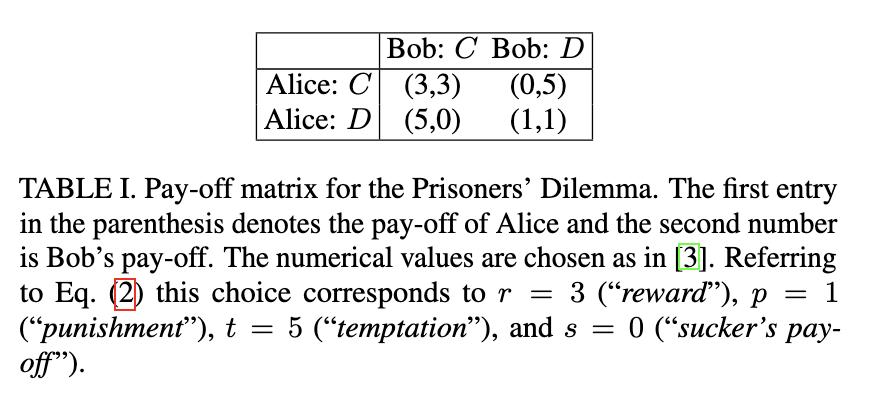


1) Alica has game strategy in Quantum Space defined through the parametrized unitary $U(\phi, \theta)$: 
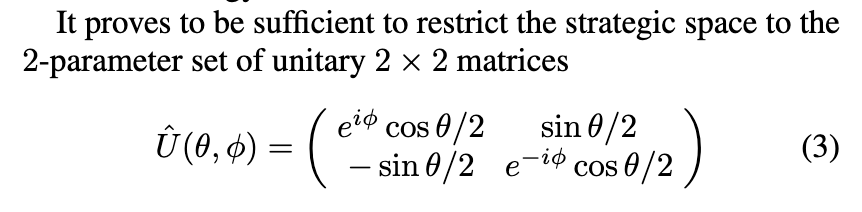

2) Bob always plays a classical strategy "Cooperate" represented by the unitary $I$ - the identity matrix. The "Defeat" strategy is represented by the $X$ quantum gate.

The qibit in $|0>$ represents "Cooperate" (state $|C>$) while the qubit in $|1>$ represents "Defeat" strategy (state $|D$).

The initial state is in $|CC>$.

In [ ]:
num_players = 2

# define the payoff matrices. Assume, the 1st matrix is Alice's payoff, the secomd matrix is Bob's payoff
payoff_matrix =[[[3, 0],
                [5, 1]],
                [[3, 5],
                [0, 1]]]

# players' matrices
# |C> strategy
# bob = [
#     [1, 0],
#     [0, 1]]

# |D> strategy
# bob = [
#     [0, 1],
#     [1, 0],
# ]


def alice_plays_quantum(theta:float, phi:float):
  """
    Set up a quantum game for Alice playing quantum, and Bob playing classically. 
    Arg:
      theta: the value of the theta parameter.
      phi: the value of the phi parameter.
    Returns: 
      qc: the class of 'qiskit.circuit.quantumcircuit.QuantumCircuit', 
            a constructed quantum circuit for the quantum game set up.
  """
  alice = np.array([[np.exp(1.0j*phi)*np.cos(theta/2), np.sin(theta/2)],
          [-np.sin(theta/2), np.exp(-1.0j*phi)*np.cos(theta/2)]])

  bob = np.array([
    [1, 0],
    [0, 1]]).astype(complex)

  qc = QuantumCircuit(num_players)
  J = 1/np.sqrt(2)*np.array([[1.0, 0.0, 0.0, 1.0j],
                             [0.0, 1.0, 1.0j, 0.0],
                             [0.0, 1.0j, 1.0, 0.0],
                             [1.0j, 0.0, 0.0, 1.0]]).astype(complex)
  J_unitary = UnitaryGate(Operator(J))
  qc.append(J_unitary, [0,1])
  qc.barrier()


  unitary_alice = UnitaryGate(Operator(alice))
  unitary_bob = UnitaryGate(Operator(bob))

  qc.append(unitary_alice, [0])
  qc.append(unitary_bob, [1])
  qc.barrier()

  Jdagger_unitary = UnitaryGate(Operator(J.conj().T))
  qc.append(Jdagger_unitary, [0,1])
  
  return qc

In [ ]:
# test run
# define the simulator
simulator = Aer.get_backend('statevector_simulator')

theta = np.pi
phi = 0.0
qc = alice_plays_quantum(theta, phi)
results = execute(qc, simulator, shots=1024).result().get_counts()
results

{'10': 1.0}

Execute the game for a several parameters $\phi, \theta$.

In [ ]:
# calculating payoffs

def get_payoff(counts):
  """
    Calculate the reward for the players after the game ends.
  """
  payoff_bob = []
  payoff_alice = []

  for strategy, prob in counts.items():
    strategy_bob = int(strategy[1])
    strategy_alice = int(strategy[0])
    payoff_bob.append(prob * payoff_matrix[0][strategy_alice][strategy_bob])
    payoff_alice.append(prob * payoff_matrix[0][strategy_bob][strategy_alice])

  return sum(payoff_alice), sum(payoff_bob)

In [ ]:
# change the size on the quantum space to explore more quantum strategies

space_size = 4

for phi in np.linspace(0, np.pi/2, space_size):
  for theta in np.linspace(0, np.pi, space_size):
    qc = alice_plays_quantum(theta, phi)
    results = execute(qc, simulator, shots=1024).result().get_counts()
    payoff_alice, payoff_bob = get_payoff(results)
    print("theta = {}, phi = {}, results = {}, Alice's payoff {}, Bob's payoff {}".format(theta, phi, results, payoff_alice, payoff_bob))
    print("Next Game")

theta = 0.0, phi = 0.0, results = {'00': 1.0}, Alice's payoff 3.0, Bob's payoff 3.0
Next Game
theta = 1.0471975511965976, phi = 0.0, results = {'00': 0.75, '10': 0.25}, Alice's payoff 2.25, Bob's payoff 3.5
Next Game
theta = 2.0943951023931953, phi = 0.0, results = {'00': 0.25, '10': 0.75}, Alice's payoff 0.75, Bob's payoff 4.5
Next Game
theta = 3.141592653589793, phi = 0.0, results = {'10': 1.0}, Alice's payoff 0.0, Bob's payoff 5.0
Next Game
theta = 0.0, phi = 0.5235987755982988, results = {'00': 0.75, '11': 0.25}, Alice's payoff 2.5, Bob's payoff 2.5
Next Game
theta = 1.0471975511965976, phi = 0.5235987755982988, results = {'00': 0.5625, '10': 0.25, '11': 0.1875}, Alice's payoff 1.875, Bob's payoff 3.125
Next Game
theta = 2.0943951023931953, phi = 0.5235987755982988, results = {'00': 0.1875, '10': 0.75, '11': 0.0625}, Alice's payoff 0.625, Bob's payoff 4.375
Next Game
theta = 3.141592653589793, phi = 0.5235987755982988, results = {'10': 1.0}, Alice's payoff 0.0, Bob's payoff 5.0
Nex

Execute for the specific value of parameters

In [ ]:
qc = alice_plays_quantum(theta = np.pi/2, phi = np.pi/4)

job = simulator.run(qc, shots=2048)
result = job.result()
outputstate = result.get_statevector(qc, decimals=3)
print(outputstate)

Statevector([0.5+0.j   , 0. +0.j   , 0. +0.707j, 0.5+0.j   ],
            dims=(2, 2))


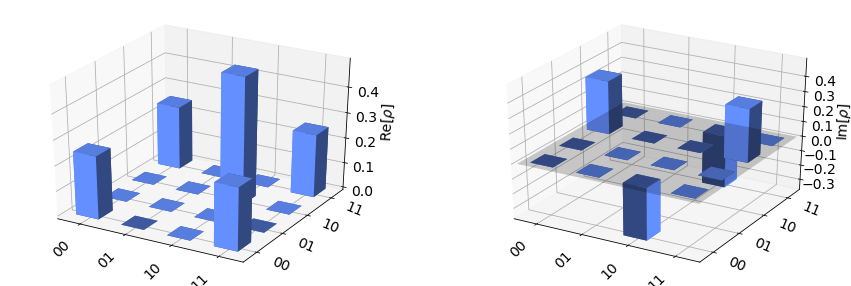

In [ ]:
from qiskit.visualization import plot_state_city
plot_state_city(outputstate)

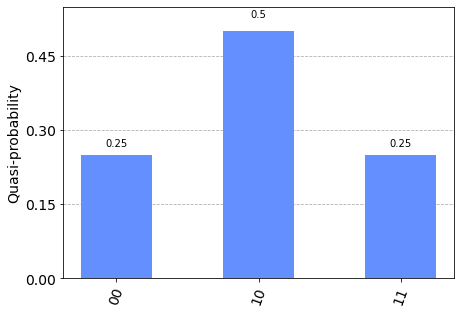

In [ ]:
from qiskit.visualization import plot_histogram
counts = result.get_counts()
plot_histogram(counts)

In [ ]:
# probabilities of a certain outcome
counts

{'00': 0.25, '10': 0.5, '11': 0.25}

# Game 2. Both Players Play Quantum.

In the following setup, Alice and Bob play quantum strategies defined by the same unitary $U(\theta, \phi)$.

In [ ]:
num_players = 2

def alice_bob_play_quantum(theta_a:float, phi_a:float, theta_b:float, phi_b:float, measure=False):
  """
    Set up a quantum game. Both players have access to quantum strategies.
    Args:
      theta_a: Theta parameter for Alice's unitary.
      phi_a: Phi parameter for Alice's unitary.
      theta_b: Theta parameter for Bob's unitary.
      phi_b: Phi parameter for Bob's unitary.
    Returns:
      qc: the class of 'qiskit.circuit.quantumcircuit.QuantumCircuit', 
            a constructed quantum circuit for the quantum game set up.
  """

  alice = np.array([
      [np.exp(1.0j*phi_a)*np.cos(theta_a/ 2), np.sin(theta_a / 2)],
      [-np.sin(theta_a / 2), np.exp(-1.0j*phi_a)*np.cos(theta_a / 2)]])

  bob = np.array([
      [np.exp(1.0j*phi_b)*np.cos(theta_b / 2), np.sin(theta_b / 2)],
      [-np.sin(theta_b / 2), np.exp(-1.0j*phi_b)*np.cos(theta_b / 2)]])

  qc = QuantumCircuit(num_players)

  J = 1/np.sqrt(2)*np.array([[1.0, 0.0, 0.0, 1.0j],
                             [0.0, 1.0, 1.0j, 0.0],
                             [0.0, 1.0j, 1.0, 0.0],
                             [1.0j, 0.0, 0.0, 1.0]]).astype(complex)
  J_unitary = UnitaryGate(Operator(J))
  qc.append(J_unitary, [0,1])
  qc.barrier()

  unitary_alice = UnitaryGate(Operator(alice))
  unitary_bob = UnitaryGate(Operator(bob))

  qc.append(unitary_alice, [0])
  qc.append(unitary_bob, [1])
  qc.barrier()

  Jdagger_unitary = UnitaryGate(Operator(J.conj().T))
  qc.append(Jdagger_unitary, [0,1])

  if measure:
    qc.measure_all()
    
  return qc

In [ ]:
alice_reward = 0
bob_reward = 0
draw = 0

space_size = 2

for phi1 in np.linspace(0, 2*np.pi, space_size):
  for theta1 in np.linspace(0, np.pi, space_size):
    for phi2 in np.linspace(0, 2*np.pi, space_size):
      for theta2 in np.linspace(0, np.pi, space_size):
        qc = alice_bob_play_quantum(theta1, phi1, theta2, phi2)
        results = execute(qc, simulator, shots=1024).result().get_counts()
        payoff_alice, payoff_bob = get_payoff(results)

        # count winning 
        if payoff_alice > payoff_bob:
          alice_reward += 1
        elif payoff_bob > payoff_alice:
          bob_reward += 1
        else:
          draw += 1
        # print results 
        print("theta_alice = {}, phi_alice = {}, theta_bob = {}, phi_bob = {}".format(theta1, phi1, theta2, phi2 ))
        print("results = {}, Alice's raward {}, Bob's reward {}".format(results, payoff_alice, payoff_bob))
        print("Next Game")
        print("===================================================")

theta_alice = 0.0, phi_alice = 0.0, theta_bob = 0.0, phi_bob = 0.0
results = {'00': 1.0}, Alice's raward 3.0, Bob's reward 3.0
Next Game
theta_alice = 0.0, phi_alice = 0.0, theta_bob = 3.141592653589793, phi_bob = 0.0
results = {'01': 1.0}, Alice's raward 5.0, Bob's reward 0.0
Next Game
theta_alice = 0.0, phi_alice = 0.0, theta_bob = 0.0, phi_bob = 6.283185307179586
results = {'00': 1.0}, Alice's raward 3.0, Bob's reward 3.0
Next Game
theta_alice = 0.0, phi_alice = 0.0, theta_bob = 3.141592653589793, phi_bob = 6.283185307179586
results = {'01': 1.0}, Alice's raward 5.0, Bob's reward 0.0
Next Game
theta_alice = 3.141592653589793, phi_alice = 0.0, theta_bob = 0.0, phi_bob = 0.0
results = {'10': 1.0}, Alice's raward 0.0, Bob's reward 5.0
Next Game
theta_alice = 3.141592653589793, phi_alice = 0.0, theta_bob = 3.141592653589793, phi_bob = 0.0
results = {'11': 1.0}, Alice's raward 1.0, Bob's reward 1.0
Next Game
theta_alice = 3.141592653589793, phi_alice = 0.0, theta_bob = 0.0, phi_bob = 6.2

In [ ]:
print("In {} games Alice gets a higher reward than Bob.". format(alice_reward))
print("In {} games, Bob gets a higher reward than Alice.".format(bob_reward))
print("In {} games Alice and Bob get equal reward.".format(draw))

In 4 games Alice gets a higher reward than Bob.
In 4 games, Bob gets a higher reward than Alice.
In 8 games Alice and Bob get equal reward.


## A New Nash Equilibrium.

When both players play a game quantum, a new type of Nash Equilibrium emerges. That is, for the strategy

$Q = U(0, \frac{\pi}{2}) = \begin{bmatrix}
i & 0 \\
0 & -i
\end{bmatrix}$

no player can gain from unilaterally deviating from the $Q$ strategy.

In [ ]:
matrix = np.array([[1.0j, 0], [0, -1.0j]])
qc = QuantumCircuit(2)
gate = UnitaryGate(Operator(matrix))

J = 1/np.sqrt(2)*np.array([[1.0, 0.0, 0.0, 1.0j],
                             [0.0, 1.0, 1.0j, 0.0],
                             [0.0, 1.0j, 1.0, 0.0],
                             [1.0j, 0.0, 0.0, 1.0]]).astype(complex)
J_unitary = UnitaryGate(Operator(J))
qc.append(J_unitary, [0,1])
qc.barrier()

qc.append(gate, [0])
qc.append(gate, [1])
qc.barrier()

Jdagger_unitary = UnitaryGate(Operator(J.conj().T))
qc.append(Jdagger_unitary, [0,1])

results = execute(qc, simulator, shots=1024).result().get_counts()
alice_payoff, bob_payoff = get_payoff(results)
print("Strategy: {}".format(results))
print("Alice's payoff is {}, Bob's payoff is {}".format(alice_payoff, bob_payoff))

Strategy: {'00': 1.0}
Alice's payoff is 3.0, Bob's payoff is 3.0


## Alice's Payoff for a Maximally Entangled Game.

Assume Alice's and Bob's strategy depend on a single parameter $t \in [-1, 1]$ only. That is, Alice's unitary operator describing her choice of strategies is 

  $U = U(t\pi, 0)$  for $t \in [0, 1]$

  $U = U(0, -t\frac{\pi}{2})$  for $t \in [-1, 0)$


The same set of strategies is defined for Bob.

The following code produces the payoff destribution for Alice's strategies.

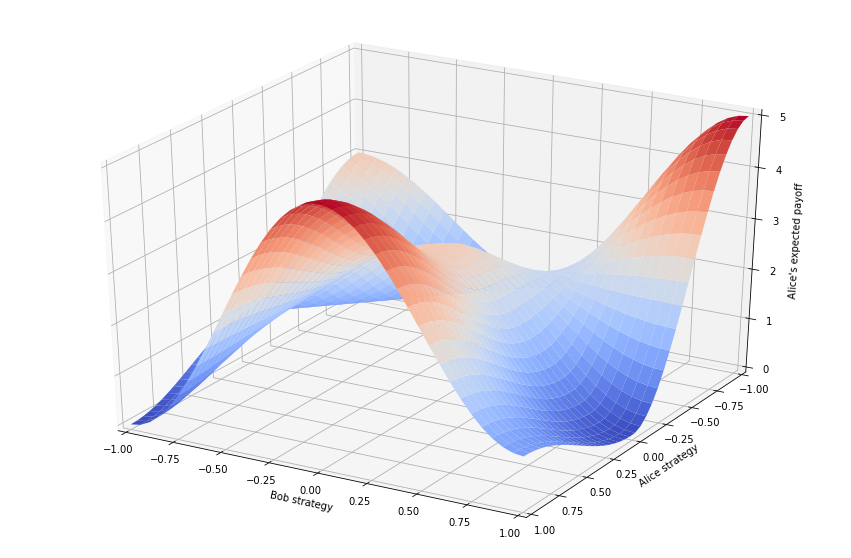

In [ ]:
import matplotlib.pyplot as plt

space_size = 40

def payoff_plot():
  """
    Plot expected payoff distribution for Alice.
  """
  x = np.linspace(1, -1, space_size)
  y = np.linspace(-1, 1, space_size)
  X, Y = np.meshgrid(x, y)
  Z = np.zeros(X.shape)

  for i in range(0,space_size):
    for inner in range(0, space_size):
      if X[inner][i] < 0 and Y[inner][i] < 0:
        qc = alice_bob_play_quantum(0, X[inner][i]*np.pi/2, 0, Y[inner][i]*np.pi/2)
        payoff_alice, _ = get_payoff(execute(qc, simulator, shots=1024).result().get_counts())
        Z[inner][i] = payoff_alice
      elif X[inner][i] >= 0 and Y[inner][i] >= 0:
        qc = alice_bob_play_quantum(X[inner][i]*np.pi, 0, Y[inner][i]*np.pi, 0)
        payoff_alice, _ = get_payoff(execute(qc, simulator, shots=1024).result().get_counts())
        Z[inner][i] = payoff_alice
      elif X[inner][i] >= 0 and Y[inner][i] < 0:
        qc = alice_bob_play_quantum(X[inner][i]*np.pi, 0, 0, Y[inner][i]*np.pi/2)
        payoff_alice, _ = get_payoff(execute(qc, simulator, shots=1024).result().get_counts())
        Z[inner][i] = payoff_alice
      elif X[inner][i] < 0 and Y[inner][i] >= 0:
        qc = alice_bob_play_quantum(0, X[inner][i]*np.pi/2, Y[inner][i]*np.pi, 0)
        payoff_alice, _ = get_payoff(execute(qc, simulator, shots=1024).result().get_counts())
        Z[inner][i] = payoff_alice

  fig = plt.figure(figsize=(15, 10))
  ax = fig.add_subplot(111, projection='3d')
  ax.plot_surface(X, Y, Z, cmap=plt.cm.coolwarm, antialiased=True)
  ax.set(xlim=(-1, 1), ylim=(1, -1), xlabel="Bob strategy", ylabel='Alice strategy', zlabel="Alice's expected payoff")
  plt.show()

payoff_plot()

# Game 3: Unequal Number of Parameters

Assume, Alice's strategy is represented by 3 parameters unitary $U(\theta, \phi, \lambda)$ while Bob's with 2 parameters unitary $U(\theta, \phi)$.



In [ ]:
def build_qcir_three_parameters(theta1, phi1, lmbda, theta2, phi2):
  """
    Set up a quantum game. Both players have access to quantum strategies space
  """
  alice = np.array([
      [np.exp(1.0j*phi1)*np.cos(theta1/2), 1.0j*np.exp(1.0j * lmbda) * np.sin(theta1/2)],
      [1.0j*np.exp(-1.0j * lmbda) * np.sin(theta1/2), np.exp(-1.0j*phi1)*np.cos(theta1/2)]])

  bob = np.array([
      [np.exp(1.0j*phi2)*np.cos(theta2/2), np.sin(theta2/2)],
      [-np.sin(theta2/2), np.exp(-1.0j*phi2)*np.cos(theta2/2)]])

  qc = QuantumCircuit(num_players)

  J = 1/np.sqrt(2)*np.array([[1.0, 0.0, 0.0, 1.0j],
                             [0.0, 1.0, 1.0j, 0.0],
                             [0.0, 1.0j, 1.0, 0.0],
                             [1.0j, 0.0, 0.0, 1.0]]).astype(complex)
  J_unitary = UnitaryGate(Operator(J))
  qc.append(J_unitary, [0,1])
  qc.barrier()

  unitary_alice = UnitaryGate(Operator(alice))
  unitary_bob = UnitaryGate(Operator(bob))

  qc.append(unitary_alice, [0])
  qc.append(unitary_bob, [1])
  qc.barrier()
  
  Jdagger_unitary = UnitaryGate(Operator(J.conj().T))
  qc.append(Jdagger_unitary, [0,1])
  
  return qc

In [ ]:
alice_reward = 0
bob_reward = 0
draw = 0

space_size = 4

for phi1 in np.linspace(-np.pi, np.pi, space_size):
  for theta1 in np.linspace(0, np.pi, space_size):
    for phi2 in np.linspace(-np.pi, np.pi, space_size):
      for theta2 in np.linspace(0, np.pi, space_size):
        for lmbda in np.linspace(-np.pi, np.pi, 2*space_size):
          qc = build_qcir_three_parameters(theta1, phi1, lmbda, theta2, phi2)
          results = execute(qc, simulator, shots=1024).result().get_counts()
          payoff_alice, payoff_bob = get_payoff(results)

          # count winning 
          if payoff_alice > payoff_bob:
            alice_reward += 1
          elif payoff_bob > payoff_alice:
            bob_reward += 1
          else:
            draw += 1
          # print results 
          print("theta_alice = {}, phi_alice = {}, theta_bob = {}, phi_bob = {}".format(theta1, phi1, theta2, phi2 ))
          print("results = {}, Alice's payoff {}, Bob's payoff {}".format(results, payoff_alice, payoff_bob))
          print("Next Game")
          print("===================================================")

Streaming output truncated to the last 5000 lines.
theta_alice = 2.0943951023931953, phi_alice = -1.0471975511965979, theta_bob = 3.141592653589793, phi_bob = -3.141592653589793
results = {'00': 0.291554649766382, '01': 0.0625, '10': 0.1875, '11': 0.458445350233618}, Alice's payoff 1.6456092995327638, Bob's payoff 2.270609299532764
Next Game
theta_alice = 2.0943951023931953, phi_alice = -1.0471975511965979, theta_bob = 3.141592653589793, phi_bob = -3.141592653589793
results = {'00': 0.75, '01': 0.0625, '10': 0.1875}, Alice's payoff 2.5625, Bob's payoff 3.1875
Next Game
theta_alice = 2.0943951023931953, phi_alice = -1.0471975511965979, theta_bob = 0.0, phi_bob = -1.0471975511965979
results = {'00': 0.0625, '01': 0.1875, '10': 0.5625, '11': 0.1875}, Alice's payoff 1.3125, Bob's payoff 3.1875
Next Game
theta_alice = 2.0943951023931953, phi_alice = -1.0471975511965979, theta_bob = 0.0, phi_bob = -1.0471975511965979
results = {'00': 0.0625, '01': 0.100105548063815, '10': 0.649894451936184, 

In [ ]:
print("In {} games Alice gets a higher reward than Bob.". format(alice_reward))
print("In {} games, Bob gets a higher reward than Alice.".format(bob_reward))
print("In {} games Alice and Bob get equal reward.".format(draw))

In 896 games Alice gets a higher reward than Bob.
In 872 games, Bob gets a higher reward than Alice.
In 280 games Alice and Bob get equal reward.


# Playing on IBM Quantum Device

In [ ]:
!python3 -m pip install -q qiskit-ibm-provider

     |████████████████████████████████| 221 kB 4.1 MB/s 


In [ ]:
from qiskit.providers.ibmq import least_busy
from qiskit_ibm_provider import IBMProvider

provider = IBMProvider()
# ====================================
# pass IBM API Token
# ====================================
provider.save_account(token=, overwrite=True)


small_devices = provider.backends(filters=lambda x: x.configuration().n_qubits == 5 and not x.configuration().simulator)
least_busy(small_devices)

<IBMBackend('ibmq_lima')>

In [ ]:
backend = least_busy(small_devices)

In [ ]:
qc = alice_bob_play_quantum(theta_a = 0, phi_a = 0, theta_b = np.pi/2, phi_b = 0, measure=True)
job = execute(qc, backend, optimization_level=2)
result = job.result()

In [ ]:
counts = result.get_counts()
counts

{'00': 2053, '01': 1876, '10': 37, '11': 34}

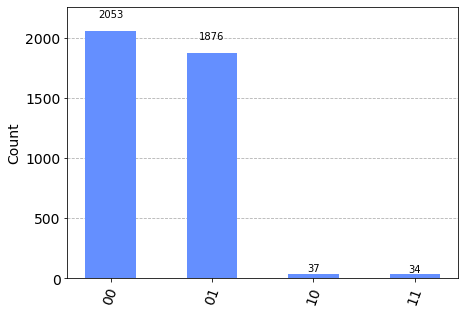

In [ ]:
plot_histogram(counts)

Compare with a quantum simulator.

{'00': 503, '01': 521}


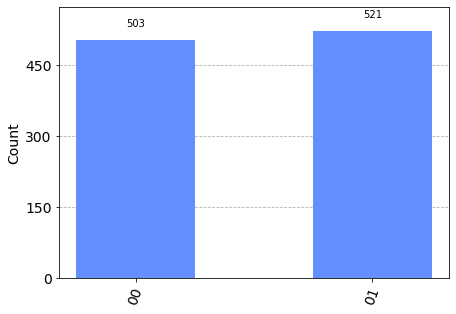

In [ ]:
job = execute(qc, backend=Aer.get_backend('statevector_simulator'), shots=1024)
result = job.result()
counts = result.get_counts()
print(counts)
plot_histogram(counts)

The strategies $|10>$ and $|11>$ are due to the noise on real quantum hardware and can be disregarded.

# Mixed Stategies Game

Alice and Bob can play a game in mixed strategies. That is a game when a player chooses a strategy according to a probability distribution over their actions. 

In Quantum Mechanics, a mixed state consisting of several possible outcome pure states $\phi_i$ each with probability of occurence $p_i$ is defined as a density matrix:

$\rho = \sum_{j}p_j |\phi_j> <\phi_j|$.

In Qiskit, the density matrix can be defined using the implemenation of the Qiskit class [DensityMatrix](https://qiskit.org/documentation/stubs/qiskit.quantum_info.DensityMatrix.html?highlight=qiskit%20quantum_info%20densitymatrix#qiskit.quantum_info.DensityMatrix).

The density matrix of the maximally entangled initial state is then evolved under the unitary operators (strategies). The `evolve()`method of the DensityMatrix class has been used to play strategies with corresponding probability distribution. 

The classical probability for cooperation is given by $p = cos(\theta/2)^2$.

In [ ]:
from functools import reduce
from operator import add
from qiskit import quantum_info as qi

def mixed_strategy(alpha_a:float, alpha_b:float):
  """
    Set up a quantum game. Both players have access to quantum strategies.
    Args:
      theta_a: Theta parameter for Alice's unitary.
      phi_a: Phi parameter for Alice's unitary.
      theta_b: Theta parameter for Bob's unitary.
      phi_b: Phi parameter for Bob's unitary.
    Returns:
      qc: the class of 'qiskit.circuit.quantumcircuit.QuantumCircuit', 
            a constructed quantum circuit for the quantum game set up.
  """

  qc = QuantumCircuit(2)
  # Alice strategies
  unitary1_a = np.eye(2).astype(complex)
  unitary2_a = np.array([[-1.0j, 0],
                        [0, 1.0j]])

  # Bob's strategies
  unitary1_b = np.array([[0, 1],
                        [-1, 0]]).astype(complex)
  unitary2_b = np.array([[0, -1.0j],
                        [-1.0j, 0]]).astype(complex)

  # define probabilities for Alice
  p1_a = np.cos(alpha_a / 2) ** 2
  p2_a = np.sin(alpha_a/ 2) ** 2

  # define probabilities for Bob
  p1_b = np.cos(alpha_b / 2) ** 2
  p2_b = np.sin(alpha_b/ 2) ** 2

  # define the set of actions and their probability distribution.
  mixed_strategy = [[(p1_a, unitary1_a), (p2_a, unitary2_a)], [(p1_b, unitary1_b), (p2_b, unitary2_b)]]

  identity = np.eye(2)

  J = 1/np.sqrt(2)*np.array([[1.0, 0.0, 0.0, 1.0j],
                             [0.0, 1.0, 1.0j, 0.0],
                             [0.0, 1.0j, 1.0, 0.0],
                             [1.0j, 0.0, 0.0, 1.0]]).astype(complex)

  J_unitary = UnitaryGate(Operator(J))
  qc.append(J_unitary, [0, 1])

  rho = qi.DensityMatrix.from_instruction(qc)

  for index, strategy in enumerate(mixed_strategy):
    rho = reduce(add,  (prob * rho.evolve(np.kron(*[strat if index == player else identity for player in range(num_players)])) for prob, strat in strategy))

  rho = rho.evolve(Operator(J.conj().T))
  return rho.probabilities()
  

In [ ]:
payoff_matrix =[[[3, 0],
                [5, 1]],
                [[3, 5],
                [0, 1]]]

for alpha_a in np.linspace(0, np.pi, 4):
  for alpha_b in np.linspace(0, np.pi, 2):
    print("alpha_a = ", alpha_a)
    print("alpha_b = ", alpha_b)
    prob = mixed_strategy(alpha_a, alpha_b)
    print("prob = ", prob)
    alice_matrix = np.reshape(payoff_matrix[0], (1,4))
    bob_matrix = np.reshape(payoff_matrix[1], (1,4))
    print("Alice's Payoff = ", np.round(np.dot(prob, alice_matrix[0]), 3))
    print("Bob's Payoff = ", np.round(np.dot(prob, bob_matrix[0]),3))
    print("=======================")


In [ ]:
# probability of 1/2 and 1/2 yeilds the payoffs of 2.5 for each player.
prob = mixed_strategy(np.pi/2, np.pi/2)
print("prob = ", prob)
alice_matrix = np.reshape(payoff_matrix[0], (1,4))
bob_matrix = np.reshape(payoff_matrix[1], (1,4))
print("Alice's Payoff = ", np.round(np.dot(prob, alice_matrix[0]), 3))
print("Bob's Payoff = ", np.round(np.dot(prob, bob_matrix[0]),3))